Robust MPC: Simulation with linearized rocket system

In [8]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import sys, os
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from LandMPC_template.MPCControl_z import MPCControl_z
from src.rocket import Rocket
from src.pos_rocket_vis import *

# Require ipympl
%matplotlib widget 

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

# Rocket setup
Ts  = 1/20
rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
rocket.mass = 1.7 # Do not change!!!

# Visualization setup
vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1

sim_time = 20  # simulation length in seconds
x0 = np.array([0,0,0,0,0,30*np.pi/180,0,0,0,3.,2.,10.])
x_ref = np.array([0.]*9+[1.,0.,3.])
xs, us = rocket.trim(x_ref)
print("Linearization around a steady state:")
print("x_ref = ", x_ref)
print("xs = ", xs)
print("us = ", us)
sys = rocket.linearize_sys(xs, us)
A, B = sys.A, sys.B
H = 20
mpc = MPCControl_z(A, B, xs, us, Ts, H)

Linearization around a steady state:
x_ref =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3.]
xs =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3.]
us =  [ 0.          0.         56.66666667  0.        ]


c:\Users\tomso\anaconda3\envs\mpc2025\Lib\site-packages\cvxpy\reductions\solvers\solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(


AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=399, step=2), IntSlider(value=0…

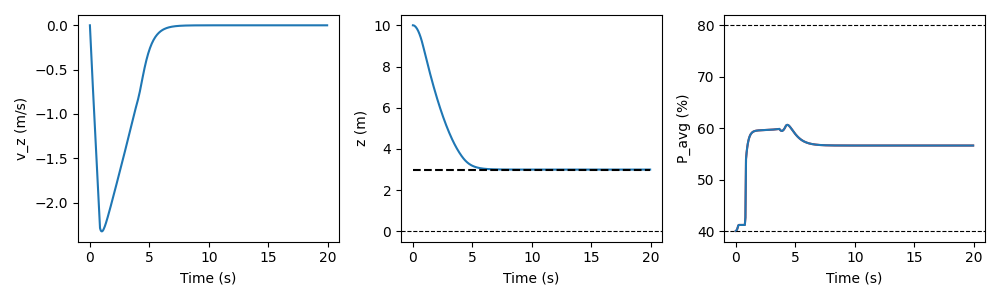

In [10]:
t_cl, x_cl, u_cl = rocket.simulate_subsystem(mpc, sim_time, x0, w_type='no_noise')
vis.animate(t_cl[:-1], x_cl[:,:-1], u_cl)
plot_static_states_inputs(t_cl[:-1], x_cl[:,:-1], u_cl, xs, 'sys_z')

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=399, step=2), IntSlider(value=0…

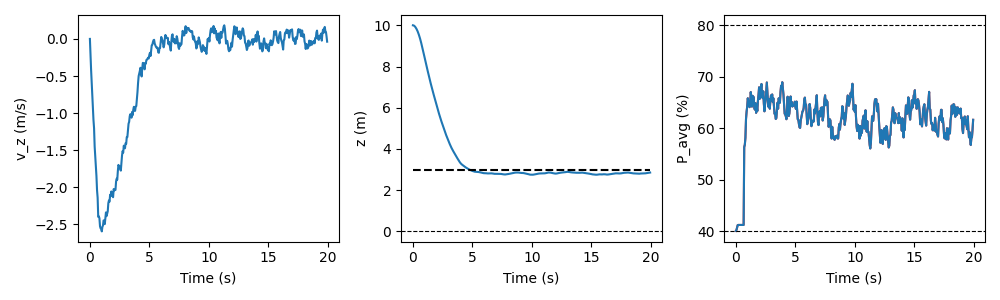

In [11]:
t_cl, x_cl, u_cl = rocket.simulate_subsystem(mpc, sim_time, x0, w_type='random')
vis.animate(t_cl[:-1], x_cl[:,:-1], u_cl)
plot_static_states_inputs(t_cl[:-1], x_cl[:,:-1], u_cl, xs, 'sys_z')

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=399, step=2), IntSlider(value=0…

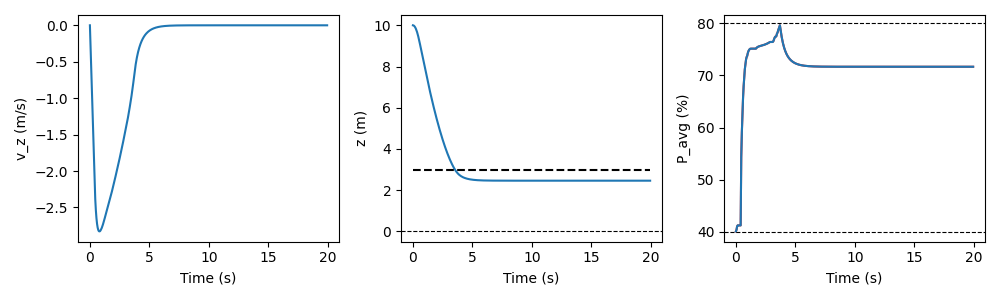

In [12]:
t_cl, x_cl, u_cl = rocket.simulate_subsystem(mpc, sim_time, x0, w_type='extreme')
vis.animate(t_cl[:-1], x_cl[:,:-1], u_cl)
plot_static_states_inputs(t_cl[:-1], x_cl[:,:-1], u_cl, xs, 'sys_z')

Maximum invariant set successfully computed after 17 iterations.
Delta u_min = -8.8580
Delta u_max = 2.4169


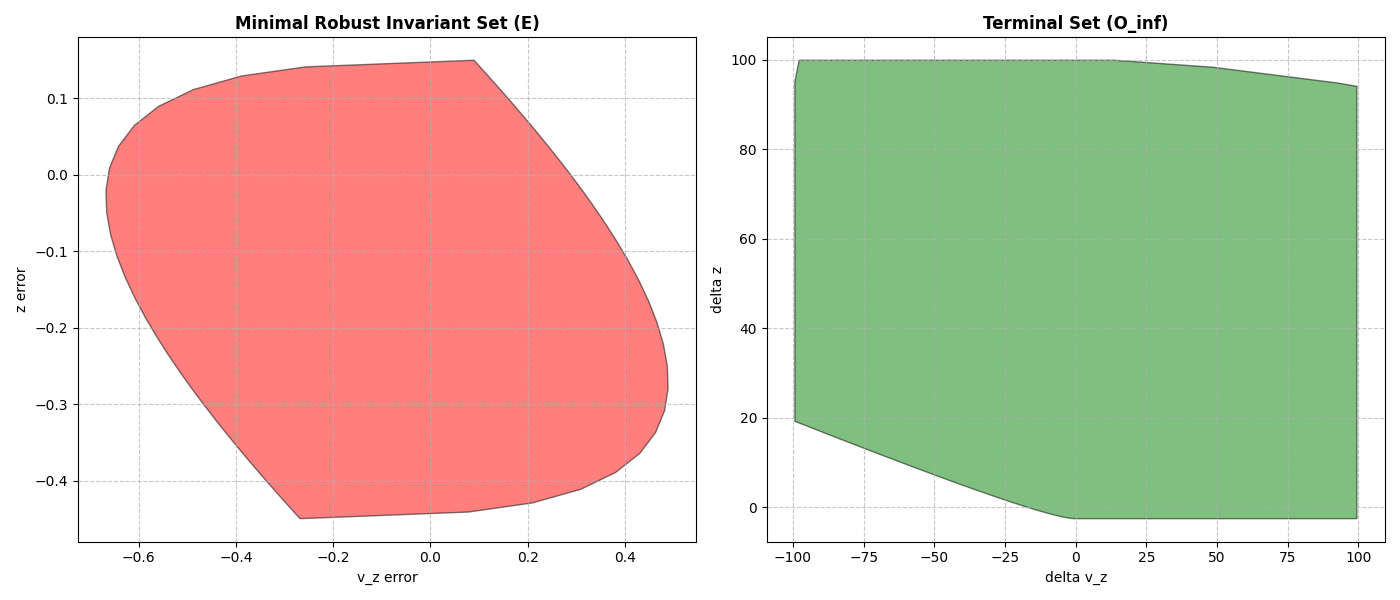

In [ ]:
###---Plotting of the sets---###



import matplotlib.pyplot as plt
import numpy as np
from control import dlqr
from mpt4py import Polyhedron

ctrl_z = mpc
Q = np.eye(ctrl_z.nx) * 100
Q[0, 0] = 50 
R = np.eye(ctrl_z.nu) * 0.1
K, _, _ = dlqr(ctrl_z.A, ctrl_z.B, Q, R)
K = -K


F_plot = np.array([
    [0, -1],  
    [0, 1],   
    [1, 0],   
    [-1, 0]   
])
f_plot = np.array([3.0, 100.0, 100.0, 100.0])
X_plot = Polyhedron.from_Hrep(F_plot, f_plot)


M = np.array([[1], [-1]])
m = np.array([80 - ctrl_z.us[0], -(40 - ctrl_z.us[0])])
U = Polyhedron.from_Hrep(M, m)


F_w = np.array([[1], [-1]])
f_w = np.array([5, 15])
W = Polyhedron.from_Hrep(F_w, f_w)


E_plot = ctrl_z.min_robust_invariant_set(ctrl_z.A + ctrl_z.B @ K, ctrl_z.B @ W)


X_tight_plot = X_plot - E_plot
U_tight = U - K @ E_plot  


O_inf_plot = ctrl_z.max_invariant_set(ctrl_z.A + ctrl_z.B @ K, X_tight_plot)




if not U_tight.is_empty:
    verts = U_tight.V
    u_min = np.min(verts)
    u_max = np.max(verts)
    
    print(f"Delta u_min = {u_min:.4f}")
    print(f"Delta u_max = {u_max:.4f}")
    
    
    



sets_to_plot = [
    ('Minimal Robust Invariant Set (E)', E_plot, ['v_z error', 'z error']),
    ('Terminal Set (O_inf)', O_inf_plot, ['delta v_z', 'delta z'])
]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i, (name, poly_set, labels) in enumerate(sets_to_plot):
    ax = axes[i]
    
    if poly_set is None or poly_set.is_empty:
        ax.text(0.5, 0.5, "Empty Set", ha='center')
        continue
    
    color = 'red' if i == 0 else 'green'
    poly_set.plot(ax=ax, color=color, alpha=0.5, linestyle='-')
    
    ax.set_title(name, fontsize=12, fontweight='bold')
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.grid(True, which='both', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()